# Обучение сети c несколькими параметрами

Параметры обучения: Vgs, Vds, L, W, Temp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import time

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [ ]:
# !python -m pip install tensorflow

Загружаем свой датасет (простой)




In [ ]:
df = pd.read_csv('mosfet_simple.csv')

In [ ]:
# df = pd.read_csv('mosfet_complicated.csv')

In [ ]:
df.shape

(4563, 6)

In [ ]:
df.describe()

,Vds,Vgs,L,W,T,Id
count,4563.000000,4563.000000,4.563000e+03,4.563000e+03,4563.000000,4.563000e+03
mean,1.500000,1.500000,5.333333e-07,5.333333e-07,25.000000,1.432282e-04
std,0.935517,0.935517,3.399719e-07,3.399719e-07,20.414652,1.994167e-04
min,0.000000,0.000000,2.000000e-07,2.000000e-07,0.000000,-2.991882e-19
25%,0.750000,0.750000,2.000000e-07,2.000000e-07,0.000000,5.848275e-07
50%,1.500000,1.500000,4.000000e-07,4.000000e-07,25.000000,6.478563e-05
75%,2.250000,2.250000,1.000000e-06,1.000000e-06,50.000000,1.998776e-04
max,3.000000,3.000000,1.000000e-06,1.000000e-06,50.000000,1.132989e-03


Найдем уникальные значения

In [ ]:
df['Vds'].unique() 

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  ])

In [ ]:
df['L'].unique() 

array([2.e-07, 4.e-07, 1.e-06])

In [ ]:
df['W'].unique() 

array([2.e-07, 4.e-07, 1.e-06])

In [ ]:
df['T'].unique() 

array([ 0., 25., 50.])

In [ ]:
# # замена отрицательных значений на нули
df.loc[df["Id"] < 0, "Id"] = 0

In [ ]:
Id=df["Id"]
Vgs=df["Vgs"]
Vds=df["Vds"]
L=df["L"]
W=df["W"]
T=df["T"]


y=np.ravel(Id)
X=df.iloc[:,0:5]

In [ ]:
X.shape, y.shape

((4563, 5), (4563,))

In [ ]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Валидация

In [ ]:
# def print_loss(y_val, y_pred):
#   loss = keras.losses.MSE(y_val, y_pred)
#   mae = keras.losses.MAE(y_val, y_pred)
#   print('MAX loss: ', np.max(loss.numpy()), 'mae: ', np.max(mae.numpy()))

#   loss_mean = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
#   mae_mean = tf.reduce_mean(mae)
#   print('MEAN loss: ', loss_mean.numpy(), 'mae: ', mae_mean.numpy())

#   value = keras.losses.MSE(np.array([0 for _ in y_val]), y_val)
#   value_mae = keras.losses.MAE(np.array([0 for _ in y_val]), y_val)
#   print('MAX value: ', np.max(value.numpy()), 'mae:', np.max(value_mae.numpy()))

#   val_mean = tf.reduce_mean(value)
#   val_mae_mean = tf.reduce_mean(value_mae)
#   print('MEAN value: ', val_mean.numpy(), 'mae:', val_mae_mean.numpy())

In [ ]:
def print_loss(y_val, y_pred):
  mse = tf.keras.metrics.mean_squared_error(y_val, y_pred)
  mae = tf.keras.metrics.mean_absolute_error(y_val, y_pred)
  mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(y_val, y_pred))
  r2 = r2_score(y_val, y_pred)

  loss = keras.losses.MSE(y_val, y_pred)

  print('MSE mean: ', np.mean(mse), '   MSE max: ', np.max(mse))
  print('MAE mean: ', np.mean(mae), '   MAE max: ', np.max(mae))
  print('MAPE: ', mape)
  print('R2: ', r2)

In [ ]:
def plot_predict(file_val, model, process_data=None, reprocess_data=None,
                 fun_x=lambda x: x, fun_y=lambda y: y, end=-1):
  df = pd.read_csv(file_val)
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

  if process_data != None:
    xval, yval = process_data(df)
  else:
    id=df["Id"]
    yval=np.ravel(id)
    xval=df.iloc[:,0:5]
  
  ypred = model.predict(xval)

  # print(ypred, yval, xval)

  if reprocess_data != None:
    ypred = reprocess_data(ypred)
    yval = reprocess_data(yval)

  print_loss(fun_y(yval), fun_y(ypred))

  # print(fun_x(xval['Vds']))

  vg=df["Vds"]
  # vg=np.ravel(vg)

  

  plt.plot(fun_x(vg)[:end], fun_y(yval)[:end], 'ro', label='Actual')
  plt.plot(fun_x(vg)[:end], fun_y(ypred)[:end], label='Predicted')

  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()


In [ ]:
class ProcessDataSimple(object):
  """Миксин создания модели подготовки данных"""
  def __init__(self, df, test_size=0.2, random_state=42):

    X, y = self._split_x_y(df)
    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _split_x_y(self, df):
    """разделение df на X и Y"""
    X = df.iloc[:,0:5]
    y = np.ravel(df["Id"])
    return X, y


  def _split_train_test(self, X, y, test_size, random_state):
    """разделение на train и test"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test


  def transform(self, df):
    """функция подготовки данных
        return: X и y"""
    return self._split_x_y(df)

  def retransform_y(self, y):
    """функция перевода,
     полученного Y в нормальный вид"""
    return y

In [ ]:
class ProcessDataLog(ProcessDataSimple):
  """Действуем на X функцией log10
      На Y функцией - 1 / log10"""

  REPLACE_ZERO_ID = 1e-20
  REPLACE_ZERO_VGS = 1e-3
  REPLACE_ZERO_VDS = 1e-3
  REPLACE_ZERO_T = 1e-3

  def __init__(self, df, test_size=0.2, random_state=42):
    data  = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def _replace_y(self, data):
    # замена отрицательных значений на нули
    data.loc[data["Id"] < 0, "Id"] = 0
    # Replace zeros
    data["Id"].replace({0:self.REPLACE_ZERO_ID}, inplace=True)

  def _replace_X(self, data):
    # Replace zeros
    data["Vgs"].replace({0:self.REPLACE_ZERO_VGS}, inplace=True)
    data["Vds"].replace({0:self.REPLACE_ZERO_VDS}, inplace=True)
    data["T"].replace({0:self.REPLACE_ZERO_T}, inplace=True)
  
  def _log_x(self, data):
    data.loc[:, 'Vds'] = data['Vds'].apply(np.log10)
    data.loc[:, 'Vgs'] = data['Vgs'].apply(np.log10)

  def _log_y(self, data):
    data.loc[:, 'Id'] = data['Id'].apply(lambda x: -1/np.log10(x))


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return X, y

  def retransform_y(self, y):
    # y_new = (y - min) / (max - min)
    # return y * (self.scaler_y.data_max_ - self.scaler_y.data_min_) + self.scaler_y.data_min_
    return 10 ** (-1 / y)

In [ ]:
class ProcessDataGenerate(ProcessDataLog):
  """Действуем на данные функцией с LOG10 и нормализируем тестувую выборку"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    X = self.generate(X)

    self.scaler_X, self.scaler_Y, X, y = self._scaler(X, y)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def generate(self, X):
    T = X['T'] + 273.15
    X = np.c_[X['Vgs'], X['Vds'], X['Vgs']**2, X['Vds']**2, X['Vgs'] * X['Vds'],
              X['Vgs']**2 * X['Vds'], X['Vgs'] * X['Vds']**2,

              1 / X['L'], 
              X['Vgs'] / X['L'], X['Vds'] / X['L'], X['Vgs']**2 / X['L'], X['Vds']**2 / X['L'], X['Vgs'] * X['Vds'] / X['L'],
              # X['Vgs']**2 * X['Vds'] / X['L'], X['Vgs'] * X['Vds']**2 / X['L'],

              1 / X['W'], 
              X['Vgs'] * X['W'], X['Vds'] * X['W'], X['Vgs']**2 * X['W'], X['Vds']**2 * X['W'], X['Vgs'] * X['Vds'] * X['W'],
              # X['Vgs']**2 * X['Vds'] * X['W'], X['Vgs'] * X['Vds']**2 * X['W'],

              1 / T, T,
              # X['Vgs'] * T, X['Vds'] * T, X['Vgs']**2 * T, X['Vds']**2 * T, X['Vgs'] * X['Vds'] * T,
              # X['Vgs']**2 * X['Vds'] * T, X['Vgs'] * X['Vds']**2 * T,
              ]
    # X = np.c_[X, X['L']]
    # X = np.c_[X, 1 / X['L'], X['Vgs'] / X['L'], X['Vds'] / X['L']]
    # X = np.c_[X, 1 / X['W'], X['Vgs'] * X['W'], X['Vds'] * X['W']]
    # X = np.c_[X, 1 / X['T'], X['Vgs'] / X['T'], X['Vds'] / X['T']]
    return X


  def _scaler(self, X, y):
    scaler_X = preprocessing.StandardScaler().fit(X)
    X = scaler_X.transform(X)

    y = y.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    y = scaler_Y.transform(y)
    return scaler_X, scaler_Y, X, y


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    X = self.generate(X)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y_in):
    y = y_in.copy()
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return 10 ** (-1 / y)

In [ ]:
from sklearn import preprocessing

In [ ]:
df = pd.read_csv('mosfet_simple.csv')
data_generate = ProcessDataGenerate(df)
print(data_generate.X_train)

[[ 5.32275155e-01  4.08926518e-01 -2.83973145e-01 ...  1.90292983e-02
   1.25749588e+00 -1.22473671e+00]
 [ 6.30767139e-01  6.30767139e-01 -2.54868042e-01 ...  3.67990509e-01
  -1.18913003e+00  1.22475304e+00]
 [-5.46153398e-01  2.43781239e-01 -1.83366314e-01 ... -6.12343194e-02
  -6.83658503e-02 -1.63302580e-05]
 ...
 [ 4.74465593e-01  6.30767139e-01 -2.98071329e-01 ...  9.00184100e-02
   1.25749588e+00 -1.22473671e+00]
 [ 5.83987569e-01 -2.05947067e-01 -2.69490896e-01 ... -6.24645886e-02
  -1.18913003e+00  1.22475304e+00]
 [-2.05947067e-01 -2.05947067e-01 -2.98071329e-01 ...  5.69795240e-02
   1.25749588e+00 -1.22473671e+00]]


# Бустинг

### Sklearn

In [ ]:
### Загружаем библиотеки и данные
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Разбираемся с признаками
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [ ]:
### Прописываем параметры для нашей модели 
params = {'n_estimators':1000,
          'max_depth':300,
          'criterion':'mse',
          'loss': 'huber',
          'learning_rate':0.03,
          'min_samples_leaf':100,
          'min_samples_split':100,
          }


### Тренируем
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.03, loss='huber',
                          max_depth=300, min_samples_leaf=100,
                          min_samples_split=100, n_estimators=1000)

In [ ]:
gbr_ = GradientBoostingRegressor(**params)
gbr_.fit(data_generate.X_train, data_generate.y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.03, loss='huber',
                          max_depth=300, min_samples_leaf=100,
                          min_samples_split=100, n_estimators=1000)

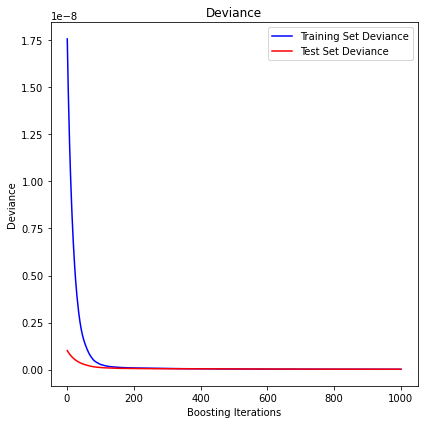

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbr.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

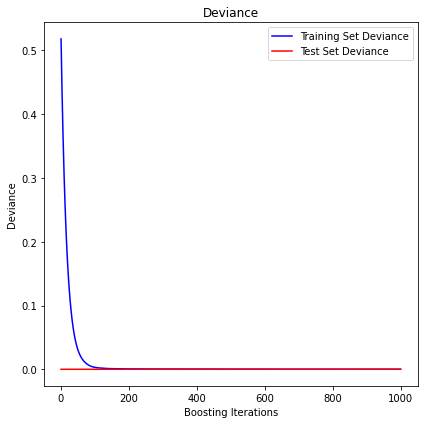

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbr_.staged_predict(data_generate.X_test)):
    test_score[i] = gbr_.loss_(data_generate.retransform_y(data_generate.y_test), data_generate.retransform_y(y_pred))

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbr_.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Найдем параметры которые наиболее влияют на результат

In [ ]:
from sklearn.inspection import permutation_importance

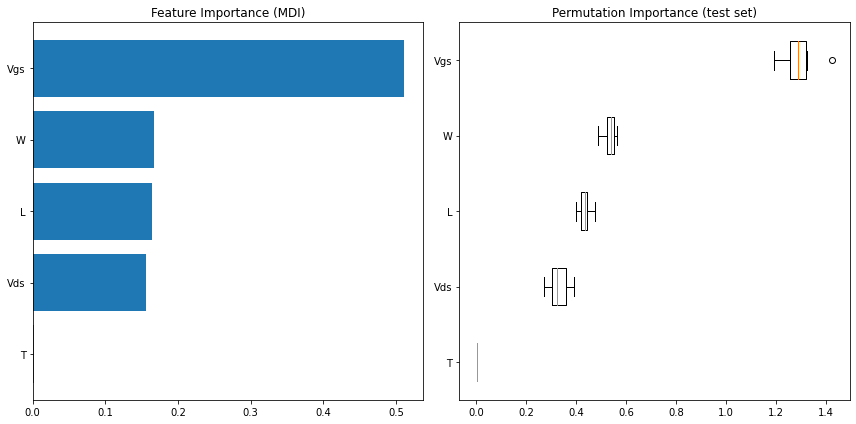

In [ ]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(['Vds', 'Vgs', 'L', 'W', 'T'])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(['Vds', 'Vgs', 'L', 'W', 'T'])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

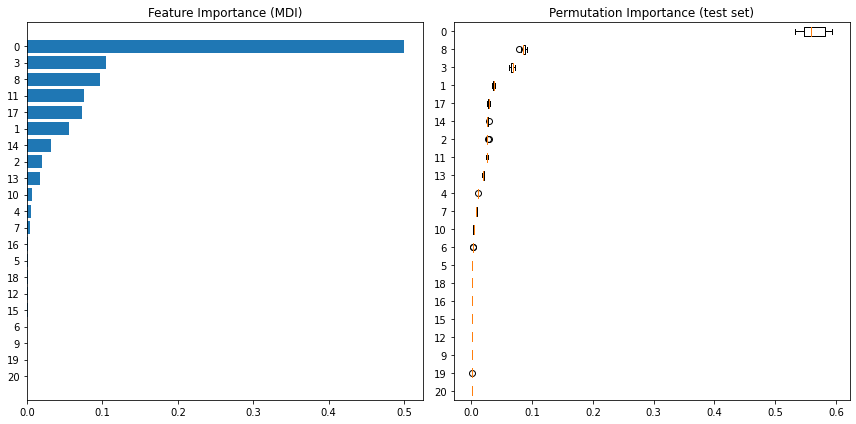

In [ ]:
feature_importance = gbr_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array([i for i in range(21)])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbr_, data_generate.X_test, data_generate.y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array([i for i in range(21)])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
### Вычисляем точность
train_accuracy_score=gbr.score(X_train,y_train)
print(train_accuracy_score)

test_accuracy_score=gbr.score(X_test,y_test)
print(test_accuracy_score)

### Предсказание
y_pred = gbr.predict(X_test)

### И среднеквадратичную ошибку
print_loss(y_test,y_pred)

0.9963410818660202
0.9955189288524484
MSE mean:  1.8743888534683556e-10    MSE max:  1.8743888534683556e-10
MAE mean:  4.650164308193492e-06    MAE max:  4.650164308193492e-06
MAPE:  1036.7386496601084
R2:  0.9955189288524484


In [ ]:
### Вычисляем точность
train_accuracy_score=gbr_.score(data_generate.X_train, data_generate.y_train)
print(train_accuracy_score)

test_accuracy_score=gbr_.score(data_generate.X_test, data_generate.y_test)
print(test_accuracy_score)

### Предсказание
y_pred = gbr_.predict(data_generate.X_test)

### И среднеквадратичную ошибку
print_loss(y_test , data_generate.retransform_y(y_pred))

0.996099825793277
0.996391403310868
MSE mean:  2.1426478094569472e-11    MSE max:  2.1426478094569472e-11
MAE mean:  2.037544154148001e-06    MAE max:  2.037544154148001e-06
MAPE:  1.9244898124100178
R2:  0.9994877606500617


In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

  xval = scl.transform(xval)
  return xval, yval

MSE mean:  1.2284408543371033e-12    MSE max:  1.2284408543371033e-12
MAE mean:  7.519945182127605e-07    MAE max:  7.519945182127605e-07
MAPE:  143.20829385992963
R2:  0.07215509449911739
MSE mean:  1.9228283227639632e-12    MSE max:  1.0628575353688615e-11
MAE mean:  1.052274726129871e-06    MAE max:  3.237712568298688e-06
MAPE:  94.19690899823371
R2:  0.12039514235282045


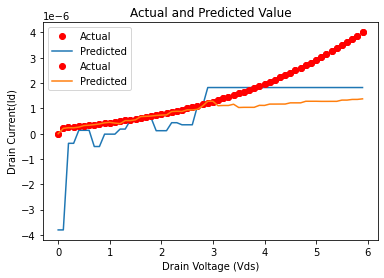

In [ ]:
plot_predict('mosfet_val_2.csv', gbr, process_data=process_data)
plot_predict('mosfet_val_2.csv', gbr_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  1.260980319451145e-10    MSE max:  1.260980319451145e-10
MAE mean:  9.51666833778768e-06    MAE max:  9.51666833778768e-06
MAPE:  225.40940991392887
R2:  0.9187756259630546
MSE mean:  3.3357352609079646e-09    MSE max:  2.506015766249644e-08
MAE mean:  4.2634125950345285e-05    MAE max:  0.0001545976222766653
MAPE:  2562.910819622551
R2:  0.49656895345494856


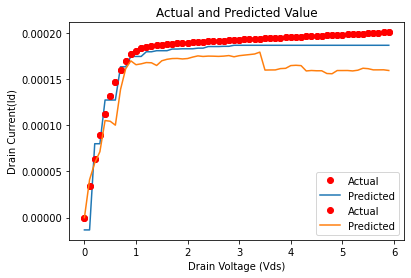

In [ ]:
plot_predict('mosfet_val_3.csv', gbr, process_data=process_data)
plot_predict('mosfet_val_3.csv', gbr_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  5.062851528748893e-11    MSE max:  5.062851528748893e-11
MAE mean:  4.089519808377607e-06    MAE max:  4.089519808377607e-06
MAPE:  157.21664311422296
R2:  0.9665239981347086
MSE mean:  7.724620576378216e-09    MSE max:  1.860421444595373e-08
MAE mean:  7.345986094750181e-05    MAE max:  0.0001278060548732143
MAPE:  1619.4353611749193
R2:  -3.1595240873617296


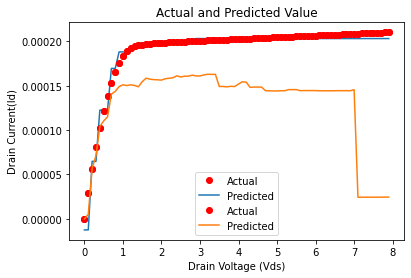

In [ ]:
plot_predict('mosfet_val_5.csv', gbr, process_data=process_data)
plot_predict('mosfet_val_5.csv', gbr_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

Посчитаем loss внутри области обучения

In [ ]:
df_val = pd.read_csv('data_val_in.csv')

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = gbr.predict(xval)

print_loss(yval, y_pred)

MSE mean:  3.676776465824104e-08    MSE max:  3.676776465824104e-08
MAE mean:  0.00017378808775329313    MAE max:  0.00017378808775329313
MAPE:  29977.82626005776
R2:  -0.4097019932497299


Также посчитаем вне области обучения

In [ ]:
df_val = pd.read_csv('data_val_out.csv')
xval=df_val.iloc[:,0:5]
yval=np.ravel(df_val["Id"])
y_pred = gbr.predict(xval)

print_loss(yval, y_pred)

MSE mean:  2.929289952288053e-07    MSE max:  2.929289952288053e-07
MAE mean:  0.0003426396956053044    MAE max:  0.0003426396956053044
MAPE:  17817.774141717073
R2:  0.024258762722660587


### CatBoost

In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# catboost для регрессии
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool

In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

# применим преобразования что и при нормировке
  xval = scl.transform(xval)
  # yval = lbl.transform(yval)
  return xval, yval

In [ ]:
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

In [ ]:
### Разбираемся с признаками

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
train_dataset = Pool(X_train, y_train)
train_dataset

In [ ]:
train_dataset_ = Pool(data_generate.X_train, data_generate.y_train)

In [ ]:
eval_dataset = Pool(X_test, y_test)
eval_dataset

In [ ]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=10000,
                          use_best_model=True,
                          loss_function='RMSE',
                          eval_metric = 'MAPE',
                          task_type="CPU",
                          devices='0:1',
                          )

In [ ]:
# Fit model
model.fit(train_dataset,
          eval_set=(X_test, y_test),
          verbose=1000,
          # plot_file='catboost.png',
          )

Learning rate set to 0.015317
0:	learn: 0.0001426	test: 0.0001444	best: 0.0001444 (0)	total: 1.05ms	remaining: 10.5s
1000:	learn: 0.0000015	test: 0.0000016	best: 0.0000016 (1000)	total: 798ms	remaining: 7.18s
2000:	learn: 0.0000008	test: 0.0000010	best: 0.0000010 (2000)	total: 1.64s	remaining: 6.54s
3000:	learn: 0.0000005	test: 0.0000007	best: 0.0000007 (3000)	total: 2.48s	remaining: 5.8s
4000:	learn: 0.0000004	test: 0.0000006	best: 0.0000006 (4000)	total: 3.32s	remaining: 4.97s
5000:	learn: 0.0000003	test: 0.0000005	best: 0.0000005 (5000)	total: 4.09s	remaining: 4.09s
6000:	learn: 0.0000003	test: 0.0000005	best: 0.0000005 (6000)	total: 4.87s	remaining: 3.24s
7000:	learn: 0.0000002	test: 0.0000004	best: 0.0000004 (7000)	total: 6.02s	remaining: 2.58s
8000:	learn: 0.0000002	test: 0.0000004	best: 0.0000004 (8000)	total: 7.45s	remaining: 1.86s
9000:	learn: 0.0000002	test: 0.0000004	best: 0.0000004 (9000)	total: 8.24s	remaining: 915ms
9999:	learn: 0.0000002	test: 0.0000003	best: 0.0000003 (

In [ ]:
# Initialize CatBoostRegressor
model_ = CatBoostRegressor(iterations=10000,
                          use_best_model=True,
                          loss_function='RMSE',
                          eval_metric = 'MAPE',
                          task_type="CPU",
                          devices='0:1',
                          )

In [ ]:
# Fit model
model_.fit(train_dataset_,
          eval_set=(data_generate.X_test, data_generate.y_test),
          verbose=1000,
          # plot_file='catboost.png',
          )

Learning rate set to 0.015317
0:	learn: 0.6553616	test: 0.6497638	best: 0.6497638 (0)	total: 2.5ms	remaining: 25s
1000:	learn: 0.0085393	test: 0.0098214	best: 0.0098214 (1000)	total: 2.22s	remaining: 20s
2000:	learn: 0.0049740	test: 0.0065908	best: 0.0065908 (2000)	total: 4.49s	remaining: 18s
3000:	learn: 0.0035296	test: 0.0053742	best: 0.0053742 (3000)	total: 9.13s	remaining: 21.3s
4000:	learn: 0.0027246	test: 0.0047481	best: 0.0047481 (4000)	total: 16.4s	remaining: 24.6s
5000:	learn: 0.0022271	test: 0.0043791	best: 0.0043791 (5000)	total: 20.7s	remaining: 20.7s
6000:	learn: 0.0018605	test: 0.0041052	best: 0.0041052 (6000)	total: 22.8s	remaining: 15.2s
7000:	learn: 0.0015869	test: 0.0039042	best: 0.0039040 (6998)	total: 25s	remaining: 10.7s
8000:	learn: 0.0013698	test: 0.0037408	best: 0.0037408 (7999)	total: 27.1s	remaining: 6.77s
9000:	learn: 0.0012062	test: 0.0036187	best: 0.0036187 (9000)	total: 29.2s	remaining: 3.24s
9999:	learn: 0.0010686	test: 0.0035186	best: 0.0035186 (9999)	to

In [ ]:
print(model.get_best_iteration())

9999


In [ ]:
print(model.get_best_score())

{'learn': {'MAPE': 1.8051642286011605e-07, 'RMSE': 2.936637751953652e-07}, 'validation': {'MAPE': 3.4941042955881985e-07, 'RMSE': 6.494385852146173e-07}}


MSE mean:  1.408750837216856e-12    MSE max:  1.408750837216856e-12
MAE mean:  7.772825450147528e-07    MAE max:  7.772825450147528e-07
MAPE:  39.56722861126219
R2:  -0.06403355344047679
MSE mean:  1.8330300111112473e-12    MSE max:  9.971082099717784e-12
MAE mean:  1.043406422959466e-06    MAE max:  3.127034073779981e-06
MAPE:  102.67639219012717
R2:  0.25192686333956327


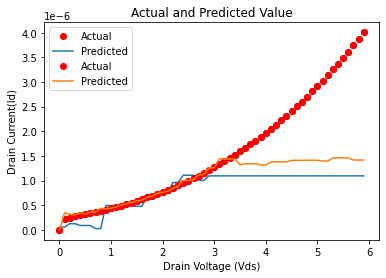

In [ ]:
plot_predict('mosfet_val_2.csv', model, process_data=process_data)
plot_predict('mosfet_val_2.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  9.21306683836339e-11    MSE max:  9.21306683836339e-11
MAE mean:  8.242662885282922e-06    MAE max:  8.242662885282922e-06
MAPE:  12.409410290455424
R2:  0.9406552524759211
MSE mean:  2.788715165754424e-09    MSE max:  3.071040376670884e-08
MAE mean:  3.0977739011608356e-05    MAE max:  0.00017185363195978555
MAPE:  2840.959611673893
R2:  0.885156885507515


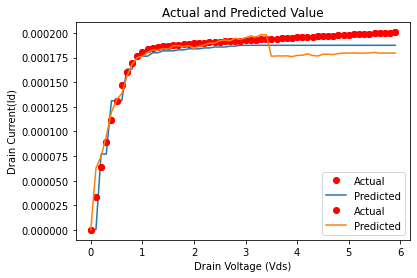

In [ ]:
plot_predict('mosfet_val_3.csv', model, process_data=process_data)
plot_predict('mosfet_val_3.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  5.3922311790221145e-11    MSE max:  5.3922311790221145e-11
MAE mean:  5.554063023143042e-06    MAE max:  5.554063023143042e-06
MAPE:  9.706331525539884
R2:  0.9643461120710302
MSE mean:  6.3238537310660415e-09    MSE max:  2.252759058604356e-08
MAE mean:  6.193189987573335e-05    MAE max:  0.0001417732416595578
MAPE:  1786.90878538667
R2:  -2.037404051753598


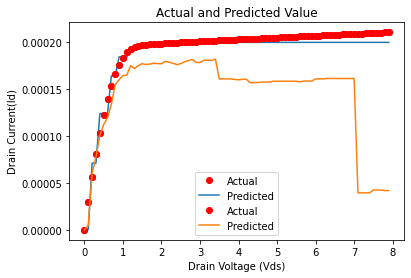

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)
plot_predict('mosfet_val_5.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

MSE mean:  9.242701691296231e-11    MSE max:  9.242701691296231e-11
MAE mean:  8.350796171779412e-06    MAE max:  8.350796171779412e-06
MAPE:  7.45922617737316
R2:  0.9295375748614398
MSE mean:  2.2918324578899583e-09    MSE max:  3.104821893247111e-08
MAE mean:  2.8574529544907098e-05    MAE max:  0.00017355300601779375
MAPE:  330.1396071323047
R2:  0.8585743720952265


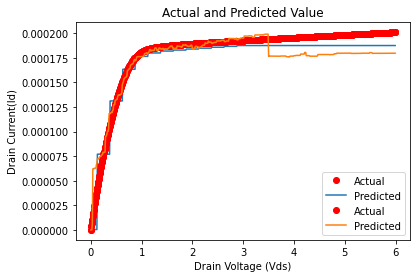

In [ ]:
plot_predict('mosfet_val_6.csv', model, process_data=process_data)
plot_predict('mosfet_val_6.csv', model_, process_data=data_generate.transform, reprocess_data=data_generate.retransform_y)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  3.643517192273647e-08    MSE max:  3.643517192273647e-08
MAE mean:  0.00017293265986768354    MAE max:  0.00017293265986768354
MAPE:  29837.412037394533
R2:  -0.3969501535189437


In [ ]:
df_val[:1000]

,Vds,Vgs,L,W,T,Id
0,0.000,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.125,0.0,2.000000e-07,2.000000e-07,0.0,9.759728e-13
2,0.250,0.0,2.000000e-07,2.000000e-07,0.0,6.993572e-13
3,0.375,0.0,2.000000e-07,2.000000e-07,0.0,9.749146e-13
4,0.500,0.0,2.000000e-07,2.000000e-07,0.0,1.252304e-12
...,...,...,...,...,...,...
995,2.500,0.0,2.000000e-07,5.000000e-07,30.0,1.402156e-11
996,2.625,0.0,2.000000e-07,5.000000e-07,30.0,1.486655e-11
997,2.750,0.0,2.000000e-07,5.000000e-07,30.0,1.574374e-11
998,2.875,0.0,2.000000e-07,5.000000e-07,30.0,1.665457e-11


In [ ]:
xval, yval = data_generate.transform(df_val[:1000])
y_pred = model_.predict(xval)
del xval
print_loss(data_generate.retransform_y(yval), data_generate.retransform_y(y_pred))

MSE mean:  6.347774937636703e-23    MSE max:  3.9248349698577216e-22
MAE mean:  5.901073016411594e-12    MAE max:  1.897983386316434e-11
MAPE:  0.005901073016411593
R2:  0.45978980346217624


In [ ]:
xval, yval = data_generate.transform(df_val[20000:21000])
y_pred = model_.predict(xval)
del xval
print_loss(data_generate.retransform_y(yval), data_generate.retransform_y(y_pred))

MSE mean:  2.221551254014311e-23    MSE max:  7.243715336141584e-23
MAE mean:  3.720266305026879e-12    MAE max:  7.838317539066002e-12
MAPE:  0.003720266305026879
R2:  0.17842809504481083


In [ ]:
xval, yval = data_generate.transform(df_val[-2000:])
y_pred = model_.predict(xval)
del xval
print_loss(data_generate.retransform_y(yval), data_generate.retransform_y(y_pred))

MSE mean:  2.877755024510917e-08    MSE max:  7.78158804512928e-08
MAE mean:  0.00013846261551955736    MAE max:  0.0002502767202607933
MAPE:  10109.540117337105
R2:  0.8594051652497157


In [ ]:
df_val = pd.read_csv('data_val_out.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  2.936756015606864e-07    MSE max:  2.936756015606864e-07
MAE mean:  0.0003426638280242622    MAE max:  0.0003426638280242622
MAPE:  17690.452597788393
R2:  0.021771830401537073


Переберем некоторые параметры и найдем более лучшие параметры

In [ ]:
model = CatBoostRegressor(
    task_type="CPU",
    devices='0:1',
)

params = {
            'iterations':[100, 500, 1000, 5000, 10000],
            'learning_rate': [1, 0.1, 0.05, 0.03, 0.01],
            'depth': [4, 6, 10, 12],
            'bootstrap_type':['Bayesian', 'No'],
}

grid_search_result = model.grid_search(params, X_scaled, y)

Выходные данные были обрезаны до нескольких последних строк (5000).
5004:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5004)	total: 5.16s	remaining: 5.15s
5005:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5005)	total: 5.16s	remaining: 5.15s
5006:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5006)	total: 5.16s	remaining: 5.15s
5007:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5007)	total: 5.17s	remaining: 5.15s
5008:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5008)	total: 5.17s	remaining: 5.15s
5009:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5009)	total: 5.17s	remaining: 5.15s
5010:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5010)	total: 5.17s	remaining: 5.14s
5011:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5011)	total: 5.17s	remaining: 5.14s
5012:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5012)	total: 5.17s	remaining: 5.14s
5013:	learn: 0.0000002	test: 0.0000007	best: 0.0000007 (5013)	total: 5.17s	remaining: 5.14s
5014:	learn:

In [ ]:
print("\nBest Params : ", grid_search_result['params'])


Best Params :  {'depth': 6, 'iterations': 10000, 'learning_rate': 0.05, 'bootstrap_type': 'No'}


In [ ]:
print(model.get_best_score())

{'learn': {'RMSE': 1.0330331593119185e-07}}


In [ ]:
print("Best Score                : ",model.best_score_)
# print("List of Target Classses : ",model.classes_)
print("Data Feature Names      : ",model.feature_names_)
print("Feature Importance      : ", model.feature_importances_)
print("Learning Rate           : ",model.learning_rate_)
print("Random Seed             : ",model.random_seed_)
print("Number of Trees         : ",model.tree_count_)
print("Number of Features      : ",model.n_features_in_)

Best Score                :  {'learn': {'RMSE': 1.0330331593119185e-07}}
Data Feature Names      :  ['0', '1', '2', '3', '4']
Feature Importance      :  [17.76119307 33.64413667 18.88366054 29.48942614  0.22158359]
Learning Rate           :  0.05000000074505806
Random Seed             :  0
Number of Trees         :  10000
Number of Features      :  5


MSE mean:  5.395284377794552e-11    MSE max:  5.395284377794552e-11
MAE mean:  5.516951271742645e-06    MAE max:  5.516951271742645e-06
MAPE:  4.977613298843405
R2:  0.9643259240629045


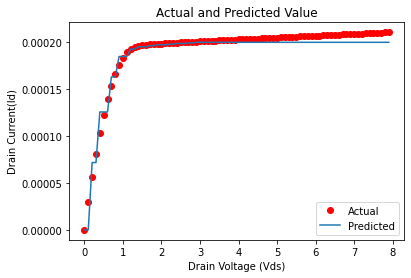

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)

MSE mean:  9.397222783105273e-11    MSE max:  9.397222783105273e-11
MAE mean:  8.438218112486669e-06    MAE max:  8.438218112486669e-06
MAPE:  7.010392127740365
R2:  0.9283595718026397


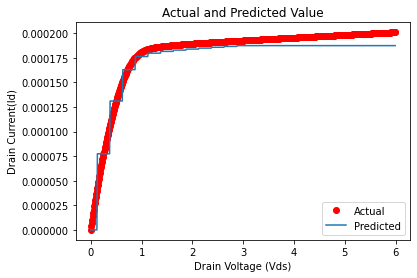

In [ ]:
plot_predict('mosfet_val_6.csv', model, process_data=process_data)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  3.6439452407012855e-08    MSE max:  3.6439452407012855e-08
MAE mean:  0.00017293292499957804    MAE max:  0.00017293292499957804
MAPE:  29818.484176995044
R2:  -0.39711427030092894


In [ ]:
df_val = pd.read_csv('data_val_out.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  2.9363370605226396e-07    MSE max:  2.9363370605226396e-07
MAE mean:  0.0003426445181201136    MAE max:  0.0003426445181201136
MAPE:  17684.297955018435
R2:  0.021911383589819255


# Poly

In [ ]:
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X_train)
X_scaled_test = scl.transform(X_test)

In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

# применим преобразования что и при нормировке
  xval = scl.transform(xval)
  # yval = lbl.transform(yval)
  return xval, yval

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [ ]:
model = LassoCV(cv=5, random_state=0, max_iter=10000)

In [ ]:
model = LassoCV()

In [ ]:
model.fit(X_scaled, y_train)

LassoCV()

In [ ]:
model.alpha_

1.2052664123230633e-07

In [ ]:
# Set best alpha
# lasso_best = Lasso(alpha=model.alpha_)
lasso_best = Lasso(alpha=0.4)
lasso_best.fit(X_scaled, y_train)

Lasso(alpha=0.4)

In [ ]:
print('R squared training set', round(lasso_best.score(X_scaled, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_scaled_test, y_test)*100, 2))

R squared training set 0.0
R squared test set -0.01


In [ ]:
df_val = pd.read_csv('data_val_in.csv')

xval, yval = process_data(df_val)

y_pred = model.predict(xval)

print_loss(yval, y_pred)

MSE mean:  8.290216708042855e-09    MSE max:  8.290216708042855e-09
MAE mean:  6.702215081037646e-05    MAE max:  6.702215081037646e-05
MAPE:  16189.000200819473
R2:  0.6821472524525423


MSE mean:  2.9770643604441948e-08    MSE max:  2.9770643604441948e-08
MAE mean:  0.00015119536790777805    MAE max:  0.00015119536790777805
MAPE:  2177.831879038986
R2:  -18.684600963984803


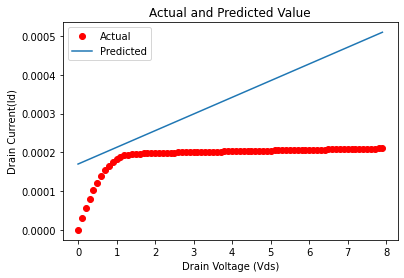

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)

In [ ]:
from sklearn.linear_model import RidgeCV
model = RidgeCV()
model.fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()
model.fit(X_train, y_train)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
  #Linear Equation of degree 2
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)

In [ ]:
X_poly

array([[1.00000e+00, 1.75000e+00, 2.25000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 2.75000e+00, 2.75000e+00, ..., 2.50000e-09,
        1.25000e-01, 6.25000e+06],
       [1.00000e+00, 1.25000e+00, 2.50000e-01, ..., 1.00000e-10,
        6.25000e-03, 3.90625e+05],
       ...,
       [1.00000e+00, 2.75000e+00, 2.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 5.00000e-01, 2.50000e+00, ..., 1.00000e-10,
        2.50000e-02, 6.25000e+06],
       [1.00000e+00, 5.00000e-01, 5.00000e-01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [ ]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train)

LinearRegression()

In [ ]:
min_i = 0
min_mse = 100

for i in range(1, 20):
  poly_reg = PolynomialFeatures(degree=i)
  X_poly = poly_reg.fit_transform(X_train)
  lin_reg = LinearRegression()
  lin_reg.fit(X_poly,y_train)

  y_pred = lin_reg.predict(poly_reg.fit_transform(X_test))
  mse = tf.keras.metrics.mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(i, float(mse), r2)
  # print_loss(y_test, y_pred)

  if min_mse > mse:
    min_mse = mse
    min_i = i

print(' === ', min_i, min_mse)

1 1.499231430086832e-08 0.6415811643121229
2 4.7919195012628335e-09 0.8854403547120685
3 3.5526829620459205e-09 0.9150665824321127
4 2.5285701376976034e-09 0.9395498822582568
5 2.545700629633731e-09 0.9391403463553074
6 4.7785539756641845e-09 0.8857598821730921
7 9.922141309696232e-09 0.7627929708259957
8 1.0025393252278238e-08 0.760324543317068
9 1.3834728043218464e-08 0.6692553919429509
10 3.492605107449833e-08 0.16502853995183375
11 7.80479916436955e-07 -17.658807260390965
12 1.6877565294905397e-08 0.5965107733970225
13 1.8505814717646075e-08 0.5575844775232515
14 1.7558594414326045e-08 0.5802295202726698
15 1.8311433733077353e-08 0.562231512315268
16 2.0239934166319376e-08 0.5161271640448919
17 2.05258726563832e-08 0.5092912787619179
18 2.023637919347713e-08 0.5162121522062559
19 2.0906530372476388e-08 0.5001909562460124
 ===  4 tf.Tensor(2.5285701376976034e-09, shape=(), dtype=float64)


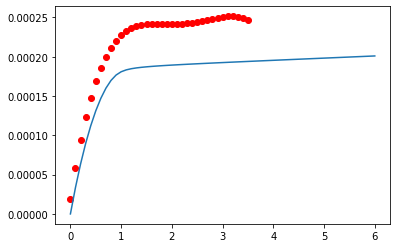

In [ ]:
df = pd.read_csv('mosfet_val_3.csv')
Id=df["Id"]
yval=np.ravel(Id)
xval=df.iloc[:,0:5]
vg=df["Vds"]

end = -25

# X_grid = np.arange(min(X),max(X),0.1)
# X_grid = X_grid.reshape(len(X_grid),1) 
y_poly = lin_reg2.predict(poly_reg.fit_transform(xval))

plt.scatter(vg[:end], y_poly[:end], color='red')
 
plt.plot(vg, yval)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = lin_reg2.predict(poly_reg.fit_transform(xval))

print_loss(yval, y_pred)

MSE mean:  0.060067194910225975    MSE max:  0.060067194910225975
MAE mean:  0.17635204650693145    MAE max:  0.17635204650693145
MAPE:  35428548.2456908
R2:  -2303017.5593533576
